In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque

In [ ]:
GAMMA = 0.99  # Facteur de réduction pour les récompenses futures
BATCH_SIZE = 64  # Taille du batch pour l'apprentissage
BUFFER_SIZE = 10000  # Taille du buffer d'expérience replay
MIN_REPLAY_SIZE = 1000  # Taille minimale du buffer avant de commencer l'apprentissage
EPSILON_START = 1.0  # Valeur initiale d'epsilon (exploration)
EPSILON_END = 0.1  # Valeur finale d'epsilon
EPSILON_DECAY = 0.995
TARGET_UPDATE_FREQ = 100  # Fréquence de mise à jour du réseau cible
LEARNING_RATE = 1e-3
NUM_EPISODES = 10000

In [8]:
env = gym.make("Taxi-v3")
observation_space = env.observation_space.n  # 500 états possibles
action_space = env.action_space.n  # 6 actions possibles

In [9]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        return self.layers(x)

In [10]:
def state_to_tensor(state):
    # One-hot encoding pour l'état
    tensor = torch.zeros(observation_space)
    tensor[state] = 1.0
    return tensor

In [11]:
online_net = DQN(observation_space, action_space)
target_net = DQN(observation_space, action_space)
target_net.load_state_dict(online_net.state_dict())  # Copie des poids initiaux

optimizer = optim.Adam(online_net.parameters(), lr=LEARNING_RATE)
replay_buffer = deque(maxlen=BUFFER_SIZE)

In [12]:
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Action aléatoire (exploration)
    else:
        state_tensor = state_to_tensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = online_net(state_tensor)
        return torch.argmax(q_values).item()  # Meilleure action (exploitation)


In [13]:
rewards_history = []
epsilon = EPSILON_START
step = 0

for episode in range(NUM_EPISODES):
    state, _ = env.reset()
    episode_reward = 0
    done = False
    truncated = False
    
    while not (done or truncated):
        # Sélection d'action
        action = select_action(state, epsilon)
        
        # Exécution de l'action
        next_state, reward, done, truncated, _ = env.step(action)
        episode_reward += reward
        
        # Stockage de l'expérience dans le buffer
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        
        # Apprentissage à partir du buffer d'expérience
        if len(replay_buffer) > MIN_REPLAY_SIZE and step % 4 == 0:
            # Échantillonnage d'un batch aléatoire
            minibatch = random.sample(replay_buffer, BATCH_SIZE)
            
            # Préparation des données
            state_batch = torch.stack([state_to_tensor(s) for s, _, _, _, _ in minibatch])
            action_batch = torch.tensor([a for _, a, _, _, _ in minibatch], dtype=torch.int64)
            reward_batch = torch.tensor([r for _, _, r, _, _ in minibatch], dtype=torch.float32)
            next_state_batch = torch.stack([state_to_tensor(s_next) for _, _, _, s_next, _ in minibatch])
            done_batch = torch.tensor([d for _, _, _, _, d in minibatch], dtype=torch.float32)
            
            # Calcul des Q-values actuelles pour les actions sélectionnées
            q_values = online_net(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)
            
            # Calcul des Q-values cibles (Double DQN)
            with torch.no_grad():
                # Sélection des actions avec le réseau online
                online_next_q_values = online_net(next_state_batch)
                best_actions = torch.argmax(online_next_q_values, dim=1)
                # Évaluation des actions avec le réseau target
                next_q_values = target_net(next_state_batch).gather(1, best_actions.unsqueeze(1)).squeeze(1)
                # Calcul de la cible
                targets = reward_batch + GAMMA * next_q_values * (1 - done_batch)
            
            # Calcul de la perte et mise à jour des poids
            loss = nn.functional.mse_loss(q_values, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if step % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(online_net.state_dict())
        
        step += 1
    
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    
    rewards_history.append(episode_reward)
    
    if (episode + 1) % 50 == 0:
        avg_reward = np.mean(rewards_history[-50:])
        print(f"Épisode {episode+1}, Récompense moyenne (50 derniers épisodes): {avg_reward:.2f}, Epsilon: {epsilon:.2f}")


Épisode 50, Récompense moyenne (50 derniers épisodes): -719.30, Epsilon: 0.78
Épisode 100, Récompense moyenne (50 derniers épisodes): -552.52, Epsilon: 0.61
Épisode 150, Récompense moyenne (50 derniers épisodes): -395.60, Epsilon: 0.47
Épisode 200, Récompense moyenne (50 derniers épisodes): -279.22, Epsilon: 0.37
Épisode 250, Récompense moyenne (50 derniers épisodes): -200.72, Epsilon: 0.29
Épisode 300, Récompense moyenne (50 derniers épisodes): -114.32, Epsilon: 0.22
Épisode 350, Récompense moyenne (50 derniers épisodes): -141.64, Epsilon: 0.17
Épisode 400, Récompense moyenne (50 derniers épisodes): -74.38, Epsilon: 0.13
Épisode 450, Récompense moyenne (50 derniers épisodes): -51.22, Epsilon: 0.10
Épisode 500, Récompense moyenne (50 derniers épisodes): -25.50, Epsilon: 0.10
Épisode 550, Récompense moyenne (50 derniers épisodes): -52.80, Epsilon: 0.10
Épisode 600, Récompense moyenne (50 derniers épisodes): -13.68, Epsilon: 0.10
Épisode 650, Récompense moyenne (50 derniers épisodes): -0

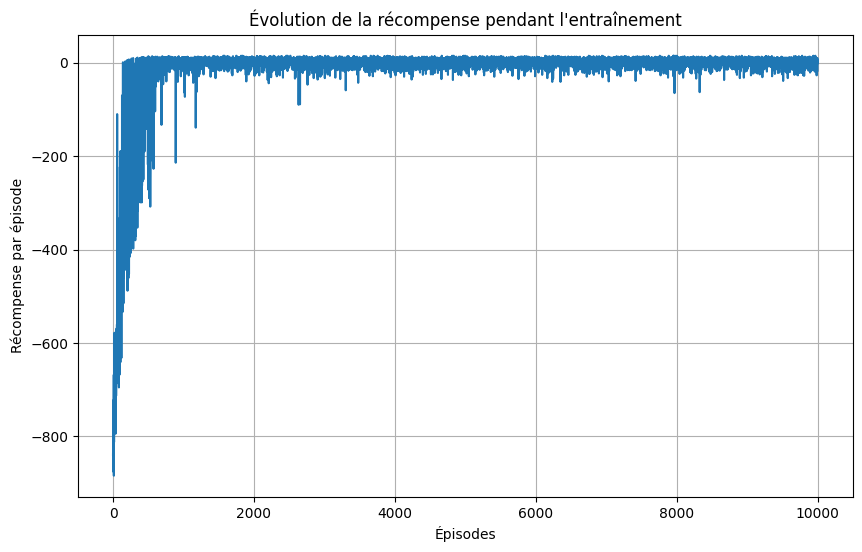

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(rewards_history)
plt.xlabel('Épisodes')
plt.ylabel('Récompense par épisode')
plt.title('Évolution de la récompense pendant l\'entraînement')
plt.grid(True)
plt.show()

In [ ]:
def demonstrate_agent(episodes=5):
    env = gym.make("Taxi-v3", render_mode="human")

    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False
        print(f"\nDémonstration de l'agent - Épisode {ep+1}")
        env.render()
        
        while not (done or truncated):
            state_tensor = state_to_tensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = online_net(state_tensor)
            action = torch.argmax(q_values).item()
            
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            
            print(f"État: {state}, Action: {action}, Récompense: {reward}")
            
            state = next_state
        
        print(f"Récompense totale: {total_reward}")


In [42]:
demonstrate_agent()


Démonstration de l'agent - Épisode 1
État: 187, Action: 1, Récompense: -1
État: 87, Action: 4, Récompense: -1
État: 99, Action: 0, Récompense: -1
État: 199, Action: 3, Récompense: -1
État: 179, Action: 0, Récompense: -1
État: 279, Action: 0, Récompense: -1
État: 379, Action: 0, Récompense: -1
État: 479, Action: 5, Récompense: 20
Récompense totale: 13

Démonstration de l'agent - Épisode 2
État: 66, Action: 2, Récompense: -1
État: 86, Action: 4, Récompense: -1
État: 98, Action: 0, Récompense: -1
État: 198, Action: 3, Récompense: -1
État: 178, Action: 0, Récompense: -1
État: 278, Action: 3, Récompense: -1
État: 258, Action: 3, Récompense: -1
État: 238, Action: 3, Récompense: -1
État: 218, Action: 0, Récompense: -1
État: 318, Action: 0, Récompense: -1
État: 418, Action: 5, Récompense: 20
Récompense totale: 10

Démonstration de l'agent - Épisode 3
État: 452, Action: 1, Récompense: -1
État: 352, Action: 1, Récompense: -1
État: 252, Action: 2, Récompense: -1
État: 272, Action: 0, Récompense:

In [43]:
torch.save(online_net.state_dict(), "taxi_dqn_model.pth")

In [44]:
online_net = DQN(observation_space, action_space)
online_net.load_state_dict(torch.load('./taxi_dqn_model.pth', weights_only=True))

<All keys matched successfully>

In [ ]:
online_net.eval()

DQN(
  (layers): Sequential(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=6, bias=True)
  )
)

: 